In [ ]:
cd ~/projects/exSEEK_training/

In [ ]:
import gc, argparse, sys, os, errno
from functools import reduce
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c
from ipywidgets import interact,interactive, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text

from collections import defaultdict
from sklearn.datasets import make_classification, make_regression, make_circles, make_moons, make_gaussian_quantiles
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix
from statsmodels.robust.scale import mad
from scipy.stats import pearsonr

random_state = np.random.RandomState(1289237)  #我固定numpy的随机种子，以使结果可重现

# load plotting functions
embed pdf; std_plot; display dataframe

In [ ]:
#setup figure template
figure_template_path = 'bin'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template
#force reload of the module
reload(figure_template)
from figure_template import display_dataframe, embed_pdf_figure, embed_pdf_pages,std_plot,legendhandle

## Introduction

### 机器学习的定义与分类

机器学习研究如何从数据中学习其隐藏的模式并预测未知数据的特征。

根据预测变量是否已知，机器学习通常分为两类：**监督学习**和**无监督学习**。
 
- 监督学习

模型通过特征和类别标签作为构建模型的输入。如果目标变量（要预测的变量）是类别信息（例如正/负），该问题称为分类问题。如果目标变量是连续的（例如身高）则为回归问题。

- 无监督学习

目标变量是未指定的。模型的目的是确定内部数据的结构（cluster）。在模型拟合之后，我们可以将新来的样本分给cluster或生成与原始数据具有相似分布的样本。无监督学习也可以用于监督学习之前的数据预处理步骤。

一个完整的、有效的机器学习工程项目却包括很多步骤，可以包括**数据导入，数据可视化理解，前处理，特征选择，模型训练，参数调整，模型预测，模型评估，后处理**等多个步骤，一个在真实世界中有效的模型可能需要工作者对数据的深入理解，以选择各个步骤合适的方法。



## 一个最简单的数据集


### 分类问题数据集
我们可以产生一个标签为离散值的用于分类问题的数据集

[sklearn.datasets.make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) 可以从一个混合高斯分布中产生样本，并且可以控制样本数量，类别数量和特征数量。

我们会产生一个数据集，共有1000个样本，两种类别，四种特征。

In [ ]:
X, y = make_classification(n_samples=1000, n_classes=2, n_features=4,
                           n_informative=2, n_redundant=0, n_clusters_per_class=1,
                           class_sep=0.9, random_state=random_state)
X.shape, y.shape #查看特征和标签的shape

### 类别和特征矩阵

In [ ]:
X,y

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
for label in np.unique(y):
    ax.scatter(X[y == label, 0], X[y == label, 1], s=10, label=str(label))
ax.legend(title='Class')
#embed_pdf_figure()

### PCA 可视化
上面只用到了前两维的特征，这显然不够全面，回忆[PCA的内容](https://lulab.gitbook.io/training/part-iii.-case-studies/case-study-2.exseek/2.2.normalization)

In [ ]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
fontlegend = {'family':'Arial',
                  'weight' : 'normal', 
                  'size' : 6.5*1}
def PCA_plot_sns(ax,data,sampleclass,method = 'Origin'):
    #X = log_transfrom(data).T
    X = StandardScaler().fit_transform(data.T)
    if method=='Origin':
        X_pca=X
    if method == 'PCA':
        transform = PCA()
        X_pca = transform.fit_transform(X)
    elif method == 'tSNE':
        transform = TSNE()
        X_pca = transform.fit_transform(X)
   
    plot_table = pd.DataFrame(X_pca[:,:2])
    plot_table.index = data.columns
    plot_table = pd.concat((plot_table,sampleclass.loc[plot_table.index]),axis=1)
    plot_table.columns = ['dimension_1','dimension_2','class']
    classnum = np.unique(plot_table.iloc[:,2]).shape[0]

    sns.scatterplot(ax=ax,data=plot_table,x="dimension_1", y="dimension_2",markers=filled_markers,alpha=0.5,
                    palette=legendhandle(np.unique(plot_table['class'])), hue="class",style="class",s=30,linewidth=0.01)
    
    std_plot(ax,'Dimension 1','Dimension 2',
             title=method, legendtitle='class',legendsort=False
             ,xbins=6,ybins=6
            )
    legend = ax.legend(prop=fontlegend,
     bbox_to_anchor=(1.2,0.9),framealpha=0,labelspacing=0.24)
    ax.legend_.get_frame()._linewidth=0
    fig.tight_layout()
    

整理成需要的输入格式，seaborn接受dataframe

In [ ]:
display(pd.DataFrame(X).head()),display(pd.DataFrame(y).head())

In [ ]:
input_table = pd.DataFrame(X)
class_label = pd.DataFrame(y)
class_label.columns = ['label']

fig, ax = plt.subplots(1,2,figsize=(12,5))
PCA_plot_sns(ax[0], input_table.T,class_label,'Origin')
PCA_plot_sns(ax[1], input_table.T,class_label,'PCA')
#embed_pdf_figure()

这说明，简单的线性分类可能难以奏效

## Data scaling

对于大多数机器学习算法，建议将feature scale到一个比较小的范围，以减少极端值的影响。

feature的规模过大或者过小都会增加数值不稳定的风险并且还使损失函数更加难以优化。
- 基于线性模型权重的特征选择方法会假定输入的feature在同样的规模上。
- 基于梯度下降算法的模型（比如神经网络）的表现和收敛速度会被没有合理scale的数据显著影响。
- 决策树和随机森林类算法对数据规模不太敏感，因为它们使用rule-based标准。

常见的数据缩放方法包括：
>
- standard/z-score scaling

Standard/z-score scaling first shift features to their centers(mean) and then divide by their standard deviation.
This method is suitable for most continous features of approximately Gaussian distribution.

$$ \text{zscore}(x_{ij}^{'}) = \frac{x_{ij} - \mu _{ij}}{\sigma _i} $$

- min-max scaling

Min-max scaling method scales data into range \[0, 1\].
This method is suitable for data concentrated within a range and preserves zero values for sparse data.
Min-max scaling is also sensitive to outliers in the data. Try removing outliers or clip data into
a range before scaling.

$$ \text{min_max}(x_{ij}^{'}) = \frac{x_{ij} - \text{min}_k \mathbf{x}_{ik}}
{\text{max}_k x_{ik} - \text{min}_k x_{ik}} $$


- abs-max scaling.

Max-abs scaling method is similar to min-max scaling, but scales data into range \[-1, 1\].
It does not shift/center the data and thus preserves signs (positive/negative) of features.
Like min-max, max-abs is sensitive to outliers.

$$ \text{max_abs}(x_{ij}^{'}) = \frac{x_{ij}}{\text{max}_k \vert x_{ik} \vert} $$

- robust scaling

Robust scaling method use robust statistics (median, interquartile range) instead of mean and standard deviation.
Median and IQR are less sensitive to outliers.
For features with large numbers of outliers or largely deviates from normal distribution, 
robust scaling is recommended.

$$ \text{robust_scale}(x_{ij}^{'}) = \frac{x_{ij} - \text{median}_k x_{ik}}
{Q_{0.75}(\mathbf{x}_i) - Q_{0.25}(\mathbf{x}_i)} $$

值得注意的是，exSEEK采用的就是最后一种标准化的方法。另外注意区分机器学习中的常规操作：对特征的标准化和RNA-seq分析中常用的样本库大小归一化的区别

### 使用standard/z-score scaling 对数据做scaling
使用方法如下：

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
#产生模拟数据，1000个数据点，均值为10，标准差为2
x = random_state.normal(10, 2, size=1000)
fig, ax = plt.subplots(1,2,figsize=(16, 6))
sns.distplot(np.ravel(x), ax=ax[0])
sns.distplot(np.ravel(StandardScaler().fit_transform(x.reshape((-1, 1)))), ax=ax[1])
ax[0].set_title('original data distribution',fontsize=20)
ax[1].set_title('scaled data distribution by standard scaling',fontsize=20)

Text(0.5, 1.0, 'scaled data distribution by robust scaling')

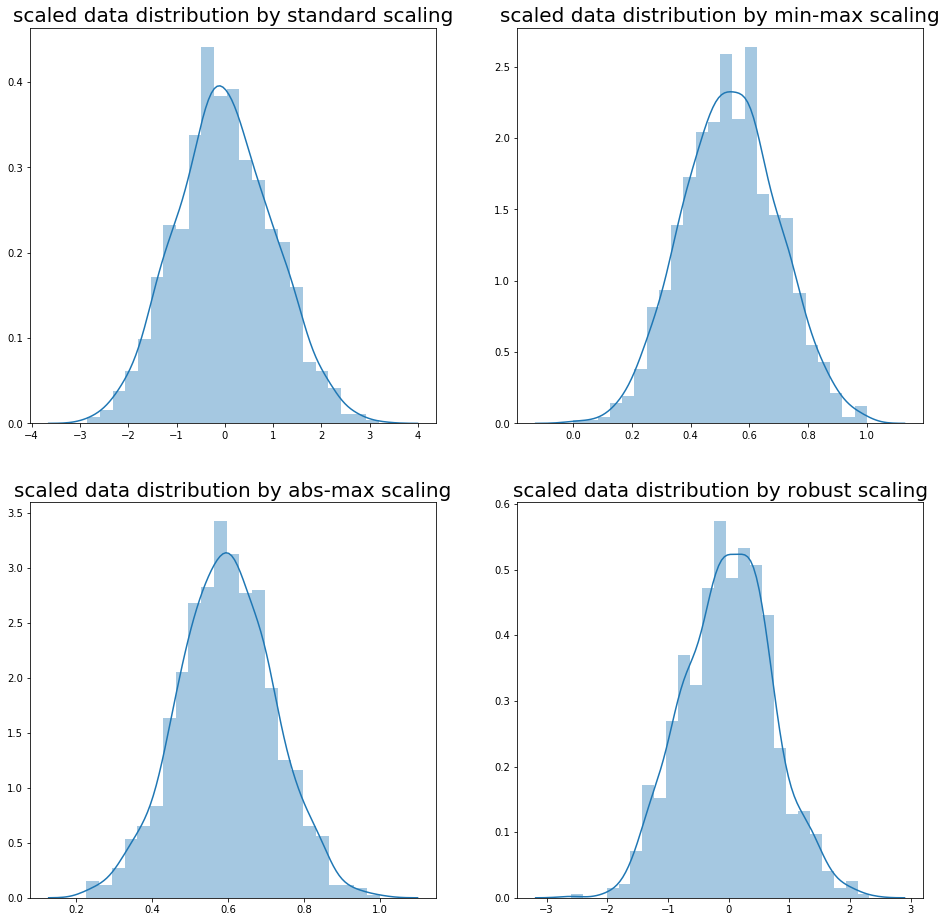

In [35]:
#产生模拟数据，1000个数据点，均值为10，标准差为2

fig, ax = plt.subplots(2,2,figsize=(16, 16))
x = random_state.normal(10, 2, size=1000)
sns.distplot(np.ravel(StandardScaler().fit_transform(x.reshape((-1, 1)))), ax=ax[0,0])
x = random_state.normal(10, 2, size=1000)
sns.distplot(np.ravel(MinMaxScaler().fit_transform(x.reshape((-1, 1)))), ax=ax[0,1])
x = random_state.normal(10, 2, size=1000)
sns.distplot(np.ravel(MaxAbsScaler().fit_transform(x.reshape((-1, 1)))), ax=ax[1,0])
x = random_state.normal(10, 2, size=1000)
sns.distplot(np.ravel(RobustScaler().fit_transform(x.reshape((-1, 1)))), ax=ax[1,1])
ax[0,0].set_title('scaled data distribution by standard scaling',fontsize=20)
ax[0,1].set_title('scaled data distribution by min-max scaling',fontsize=20)
ax[1,0].set_title('scaled data distribution by abs-max scaling',fontsize=20)
ax[1,1].set_title('scaled data distribution by robust scaling',fontsize=20)

# references
- https://mp.weixin.qq.com/s/o3Gkey3SnYBcZGdOWojDXQ
- https://github.com/rasbt/python-machine-learning-book
- https://github.com/susanli2016/Machine-Learning-with-Python/